## In this notebook we are going to discuss the EDA of the tweet sentiment data.
First we create a dataset having 1600 tweets (balanced) by staratfying the tweet data set. We are just going to do exploratory analysis with the tweet dataset.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import codecs
from collections import  Counter
import seaborn as sns
from tqdm import tqdm

from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
import gensim


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import tensorflow as tf
import sklearn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('tweet.csv')
df.head()

,sentiment_label,tweet_text
0,0,visited my friends and had a great time!!! Tom...
1,0,vicar of dibley always makes me cry love them...
2,0,Cleaning house and fighting fatigue
3,0,I can't get to sleep. I have an urge to make f...
4,0,HELLO ALL TWITTERS!! I've missed u. Been away ...


In [3]:
df.shape

(1600, 2)

In [4]:
df['sentiment_label'].value_counts()

0    800
4    800
Name: sentiment_label, dtype: int64

In [5]:
df['sentiment_label'] = df.sentiment_label.replace(4, 1)

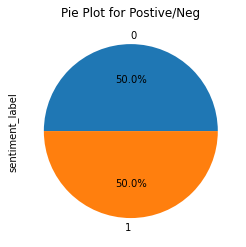

In [6]:
df['sentiment_label'].value_counts().plot.pie(center=(0, 0), radius=1.0, autopct='%1.1f%%').set_title('Pie Plot for Postive/Neg');

In [7]:
from nltk.corpus import stopwords

In [8]:
def plot_top_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    plt.bar(x,y)
    plt.title('Top 10 stopwords')

#### Top 10 Stopwords Barchart

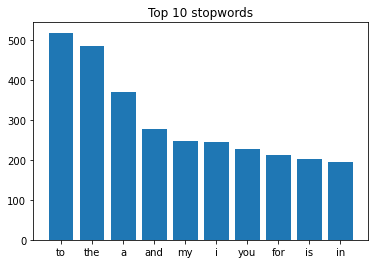

In [9]:
plot_top_stopwords_barchart(df['tweet_text'])

In [10]:
stop=set(stopwords.words('english'))
df['stopwords'] = df['tweet_text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['tweet_text','stopwords', 'sentiment_label']].head()

,tweet_text,stopwords,sentiment_label
0,visited my friends and had a great time!!! Tom...,6,0
1,vicar of dibley always makes me cry love them...,4,0
2,Cleaning house and fighting fatigue,1,0
3,I can't get to sleep. I have an urge to make f...,4,0
4,HELLO ALL TWITTERS!! I've missed u. Been away ...,4,0


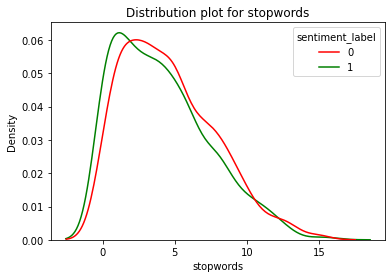

In [11]:
sns.kdeplot(x=df['stopwords'], hue=df['sentiment_label'],palette=['red', 'green']).set_title('Distribution plot for stopwords');

#### Preprocess the data

In [12]:
df_preprocess = df.copy()

In [13]:
tweets = df_preprocess.tweet_text.copy()
tweets.head()

0    visited my friends and had a great time!!! Tom...
1    vicar of dibley always makes me cry  love them...
2                 Cleaning house and fighting fatigue 
3    I can't get to sleep. I have an urge to make f...
4    HELLO ALL TWITTERS!! I've missed u. Been away ...
Name: tweet_text, dtype: object

#### Remove Characters

In [14]:
def removeWordWithChar(text, char_list):
    #Remove words in a text that contains a char from the list.
    text = text.split()
    res = [ele for ele in text if all(ch not in ele for ch in char_list)]
    res = ' '.join(res)
    return res

char_list = ['@', '#', 'http', 'www', '/']

removeWordWithChar(tweets[0], char_list)

'visited my friends and had a great time!!! Tomorrow, up at 6:00 a.m.'

In [15]:
tweets_cleaned = []
for t in tweets:
    tweets_cleaned.append(removeWordWithChar(t, char_list))

#### Tokenize

In [16]:
def tokenize(texts):
    tokenizer = nltk.RegexpTokenizer(r'\w+')

    texts_tokens = []
    for i, val in enumerate(texts):
        text_tokens = tokenizer.tokenize(val.lower())

        for i in range(len(text_tokens) - 1, -1, -1):
            if len(text_tokens[i]) < 4:
                del(text_tokens[i])

        texts_tokens.append(text_tokens)
        
    return texts_tokens

In [17]:
tweets_tokens = tokenize(tweets_cleaned)

In [18]:
def removeSW(texts_tokens):
    stopWords = set(stopwords.words('english'))
    texts_filtered = []

    for i, val in enumerate(texts_tokens):
        text_filtered = []
        for w in val:
            if w not in stopWords:
                text_filtered.append(w)
        texts_filtered.append(text_filtered)
        
    return texts_filtered

In [19]:
tweets_filtered = removeSW(tweets_tokens)

### Stemming & Lemmatisation

In [20]:
from nltk.stem import PorterStemmer
def stem(texts_filtered):
    stemmer=PorterStemmer()
    texts_stem = []

    for i, val in enumerate(texts_filtered):
        text_stem = []
        for word in val:
            text_stem.append(stemmer.stem(word))
        texts_stem.append(text_stem)
    return texts_stem

In [21]:
tweets_stem = stem(tweets_filtered)

In [22]:
def lemma(texts_filtered):
    wordnet_lemmatizer = WordNetLemmatizer()
    texts_lem = []

    for i, val in enumerate(texts_filtered):
        text_lem = []
        for word in val:
            text_lem.append(wordnet_lemmatizer.lemmatize(word))
        texts_lem.append(text_lem)
    
    return texts_lem

In [23]:
tweets_lem = lemma(tweets_stem)

In [24]:
tweets_ready = []
for tweet in tweets_lem:
    string = ' '
    string = string.join(tweet)
    tweets_ready.append(string)

In [25]:
df_preprocess['tweet'] = tweets_ready
df_preprocess['sentiment_label'] = df.sentiment_label.replace(4, 1)

In [26]:
df_preprocess.head()

,sentiment_label,tweet_text,stopwords,tweet
0,0,visited my friends and had a great time!!! Tom...,6,visit friend great time tomorrow
1,0,vicar of dibley always makes me cry love them...,4,vicar dibley alway make love bit
2,0,Cleaning house and fighting fatigue,1,clean hous fight fatigu
3,0,I can't get to sleep. I have an urge to make f...,4,sleep urg make friendship bracelet
4,0,HELLO ALL TWITTERS!! I've missed u. Been away ...,4,hello twitter miss away long much better thoug...


In [27]:
df_preprocess=df_preprocess[['sentiment_label', 'tweet']]

#### Most common words in the tweet

In [28]:
corpus=[]
new= df_preprocess['tweet'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

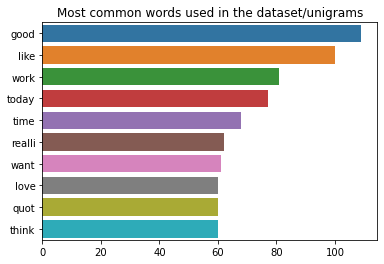

In [29]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:10]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)
plt.title('Most common words used in the dataset/unigrams');

In [30]:
# Create top 10 bigrams and trigrams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

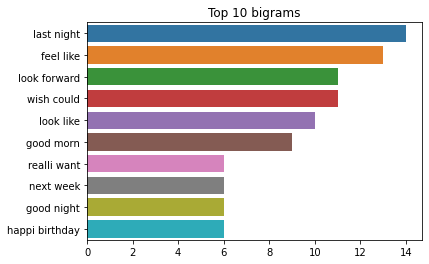

In [31]:
top_n_bigrams=get_top_ngram(df_preprocess['tweet'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams)) 
sns.barplot(x=y,y=x)
plt.title('Top 10 bigrams');

#### Plot wordcloud

In [32]:
df1=df_preprocess[df_preprocess['sentiment_label']==1]
df1= df1[['tweet']]

In [33]:
df1.head()

,tweet
800,nice much rain
801,vote opinion susan boyl
802,slip want icon chang next name
803,sent friend request
804,night museum movi pretti good


### Word Cloud for  positive  sentiment 

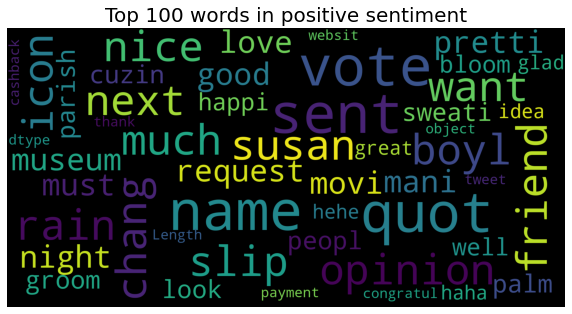

In [34]:
word_cloud = WordCloud(
                    background_color='black',
                    stopwords=set(STOPWORDS),
                    max_words=100,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(df1['tweet']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title('Top 100 words in positive sentiment', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()

### Word Cloud for  negative sentiment 

In [35]:
df0=df_preprocess[df_preprocess['sentiment_label']==0]
df0= df0[['tweet']]
df0.head()

,tweet
0,visit friend great time tomorrow
1,vicar dibley alway make love bit
2,clean hous fight fatigu
3,sleep urg make friendship bracelet
4,hello twitter miss away long much better thoug...


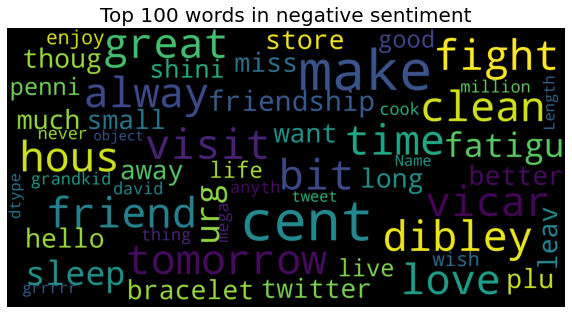

In [36]:
word_cloud = WordCloud(
                    background_color='black',
                    stopwords=set(STOPWORDS),
                    max_words=100,
                    max_font_size=40,
                    scale=5,
                    random_state=1).generate(str(df0['tweet']))
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.title('Top 100 words in negative sentiment', fontsize=20)
fig.subplots_adjust(top=2.3)
plt.imshow(word_cloud)
plt.show()